In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt 
import pandas as pd
import os
from PIL import Image

In [5]:
import sys
sys.path.insert(0, '/Users/anureddy/Desktop/GNNProject')  # Adjust the path according to the location of the notebook

from Pruning.laprune import LAP  # Import LAP function

In [6]:
data = pd.read_csv('/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GNNProject/DataPreparation/CorruptedData/Names.csv')


In [7]:
class FashionMNISTDataset(Dataset):
    def __init__(self,dataframe,root_dir,transform=None):
        self.dataframe=dataframe
        self.root_dir = root_dir
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
        image=Image.open(img_name)
        label=self.dataframe.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,image

In [8]:
transform = transforms.ToTensor()

In [9]:
root_dir = '/Users/anureddy/Desktop/SEM03/Generative_NN_for_the_Sciences/Project_proposal/GNNProject/DataPreparation/CorruptedData'
dataset = FashionMNISTDataset(dataframe=data,root_dir=root_dir,transform=transform)


In [10]:
total_images = len(dataset)
print(f'Total number of images: {total_images}')

Total number of images: 60000


In [11]:
subset_size = int(0.3 * total_images)  
indices = torch.randperm(len(dataset)).tolist()
subset_indices = indices[:subset_size]
subset_dataset = Subset(dataset, subset_indices)

In [12]:
# Split the subset dataset into train and test sets
train_size = int(0.8 * len(subset_dataset))  # 80% for training
test_size = len(subset_dataset) - train_size  # Remaining for testing

train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [13]:
images,_ = next(iter(train_dataloader))
print(images.shape)

torch.Size([64, 1, 28, 28])


In [14]:
dataiter= iter(train_dataloader)
images,labels = dataiter.__next__()
print(torch.min(images),torch.max(images))

tensor(0.) tensor(0.9725)


In [15]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_sizes, layers):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_sizes = hidden_sizes
        self.layers = layers

        # Encoder
        encoder_layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, layers):
            encoder_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(hidden_sizes[-1], bottleneck_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = [nn.Linear(bottleneck_size, hidden_sizes[-1]), nn.ReLU()]
        for i in reversed(range(1, layers)):
            decoder_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_sizes[0], input_size))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def calculate_loss(self, X):
        reconstructed = self.forward(X)
        loss = nn.MSELoss()(reconstructed, X)
        return loss

    def train_autoencoder(self, dataloader, epochs, lr=0.01, use_lap=False, prune_ratios=None, bn_factors=None, lap_interval=5):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        losses = []
        sparsity_levels = []

        for epoch in range(epochs):
            total_loss = 0
            for X_batch, _ in dataloader:
                X_batch = X_batch.float()
                X_batch = X_batch.view(X_batch.size(0), -1)

                optimizer.zero_grad()
                loss = self.calculate_loss(X_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            sparsity_levels.append(self.calculate_sparsity())  # Store sparsity level

            if use_lap and epoch % lap_interval == 0 and epoch > 0:
                self.apply_lap(prune_ratios, bn_factors)

            print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}, Sparsity Level: {sparsity_levels[-1]}')

        return losses, sparsity_levels
    def calculate_sparsity(self):
        total_weights = 0
        total_zero_weights = 0
        for param in self.parameters():
            if param.dim() > 1:  # Only consider weights of layers, not biases
                total_weights += param.numel()
                total_zero_weights += torch.sum(param == 0).item()
        sparsity_level = total_zero_weights / total_weights
        return sparsity_level


    def apply_lap(self, prune_ratios, bn_factors=None):
        weights = [param.data for param in self.parameters() if len(param.data.size()) > 1]
        masks = [torch.ones_like(weight) for weight in weights]
        
        # Assuming LAP function is correctly implemented and available
        new_masks = LAP(weights, masks, prune_ratios, bn_factors=bn_factors)
        
        # Apply new masks
        for param, mask in zip([param for param in self.parameters() if len(param.data.size()) > 1], new_masks):
            param.data.mul_(mask)

In [16]:
input_size = 784  # For MNIST
bottleneck_size = 32
hidden_sizes = [128, 64]
layers = 2
epochs = 100
lr = 0.01
autoencoder = AutoEncoder(input_size, bottleneck_size, hidden_sizes, layers)

In [17]:
losses_without_lap, sparsity_levels_without_lap = autoencoder.train_autoencoder(train_dataloader, epochs, lr, use_lap=False)


Epoch 1/100, Average Loss: 0.018546582785331542, Sparsity Level: 0.0
Epoch 2/100, Average Loss: 0.0064745966055326995, Sparsity Level: 0.0
Epoch 3/100, Average Loss: 0.005337392534646723, Sparsity Level: 0.0
Epoch 4/100, Average Loss: 0.007209830985714992, Sparsity Level: 0.0
Epoch 5/100, Average Loss: 0.006602860699511237, Sparsity Level: 0.0
Epoch 6/100, Average Loss: 0.006246824090679486, Sparsity Level: 0.0
Epoch 7/100, Average Loss: 0.005223295127766, Sparsity Level: 0.0
Epoch 8/100, Average Loss: 0.0051867190914021595, Sparsity Level: 0.0
Epoch 9/100, Average Loss: 0.00514386214936773, Sparsity Level: 0.0
Epoch 10/100, Average Loss: 0.004204379406033291, Sparsity Level: 0.0
Epoch 11/100, Average Loss: 0.004131829310208559, Sparsity Level: 0.0
Epoch 12/100, Average Loss: 0.004163116438107358, Sparsity Level: 0.0
Epoch 13/100, Average Loss: 0.004154056882899669, Sparsity Level: 0.0
Epoch 14/100, Average Loss: 0.004083251335347692, Sparsity Level: 0.0
Epoch 15/100, Average Loss: 0.0

In [18]:
prune_ratios = [0.1, 0.1, 0.1]  # Adjust based on your network architecture
autoencoder_with_lap = AutoEncoder(input_size, bottleneck_size, hidden_sizes, layers)  # Create another instance for LAP

losses_with_lap, sparsity_levels_with_lap = autoencoder_with_lap.train_autoencoder(train_dataloader, epochs, lr, use_lap=True, prune_ratios=prune_ratios, lap_interval=10)

Epoch 1/100, Average Loss: 0.01718118957968222, Sparsity Level: 0.0
Epoch 2/100, Average Loss: 0.0059296818056868185, Sparsity Level: 0.0
Epoch 3/100, Average Loss: 0.0053755585311187635, Sparsity Level: 0.0
Epoch 4/100, Average Loss: 0.005134320538491011, Sparsity Level: 0.0
Epoch 5/100, Average Loss: 0.004326868021032876, Sparsity Level: 0.0
Epoch 6/100, Average Loss: 0.004262493136856291, Sparsity Level: 0.0
Epoch 7/100, Average Loss: 0.004234904836242398, Sparsity Level: 0.0
Epoch 8/100, Average Loss: 0.004177393272726072, Sparsity Level: 0.0
Epoch 9/100, Average Loss: 0.009724229366208117, Sparsity Level: 0.0
Epoch 10/100, Average Loss: 0.00663679604522056, Sparsity Level: 0.0
Epoch 11/100, Average Loss: 0.006561741201827924, Sparsity Level: 0.0
Epoch 12/100, Average Loss: 0.006569806892010901, Sparsity Level: 0.049519856770833336
Epoch 13/100, Average Loss: 0.006563163861218426, Sparsity Level: 0.049519856770833336
Epoch 14/100, Average Loss: 0.006583525145219432, Sparsity Level:

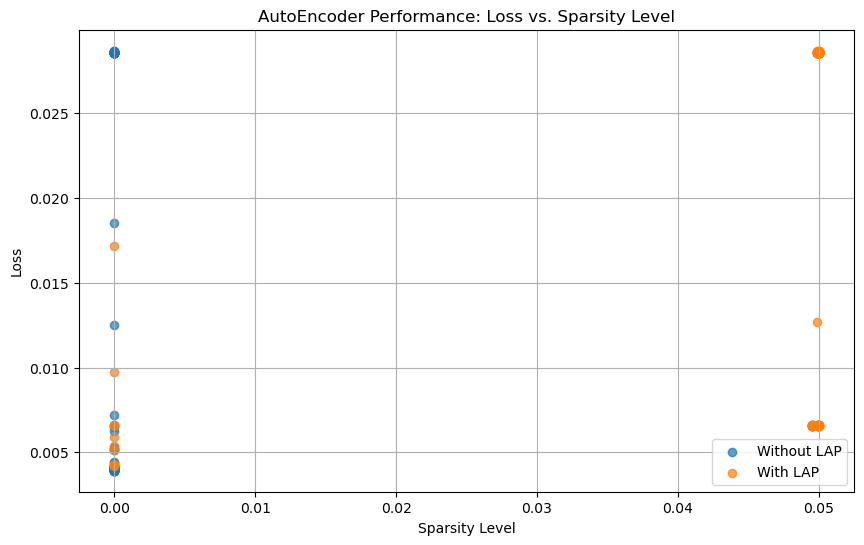

In [19]:
plt.figure(figsize=(10, 6))

# Plot for training without LAP
plt.scatter(sparsity_levels_without_lap, losses_without_lap, label='Without LAP', alpha=0.7)

# Plot for training with LAP
plt.scatter(sparsity_levels_with_lap, losses_with_lap, label='With LAP', alpha=0.7)

plt.title('AutoEncoder Performance: Loss vs. Sparsity Level')
plt.xlabel('Sparsity Level')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()